# XGB Regressor 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

from faa_p2.config import (
    CLEAN_DATA_FILE,
    DATA_SPLIT_RATIO,
    MODEL_RESULTS_FILE,
    MODELS,
    RANDOM_STATE,
    XGBR,
)

warnings.filterwarnings("ignore")


Load and split the data.

In [2]:
df = pd.read_csv(CLEAN_DATA_FILE, index_col=0)
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
y = df["medv"]
x = df.drop(columns=["medv"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=DATA_SPLIT_RATIO, random_state=RANDOM_STATE
)

Model configurations (default).

In [4]:
key = XGBR
config = MODELS[key]

In [5]:
default_model = config["class"]()
default_model.fit(x_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [6]:
default_y_pred = default_model.predict(x_test)
default_y_pred_train = default_model.predict(x_train)

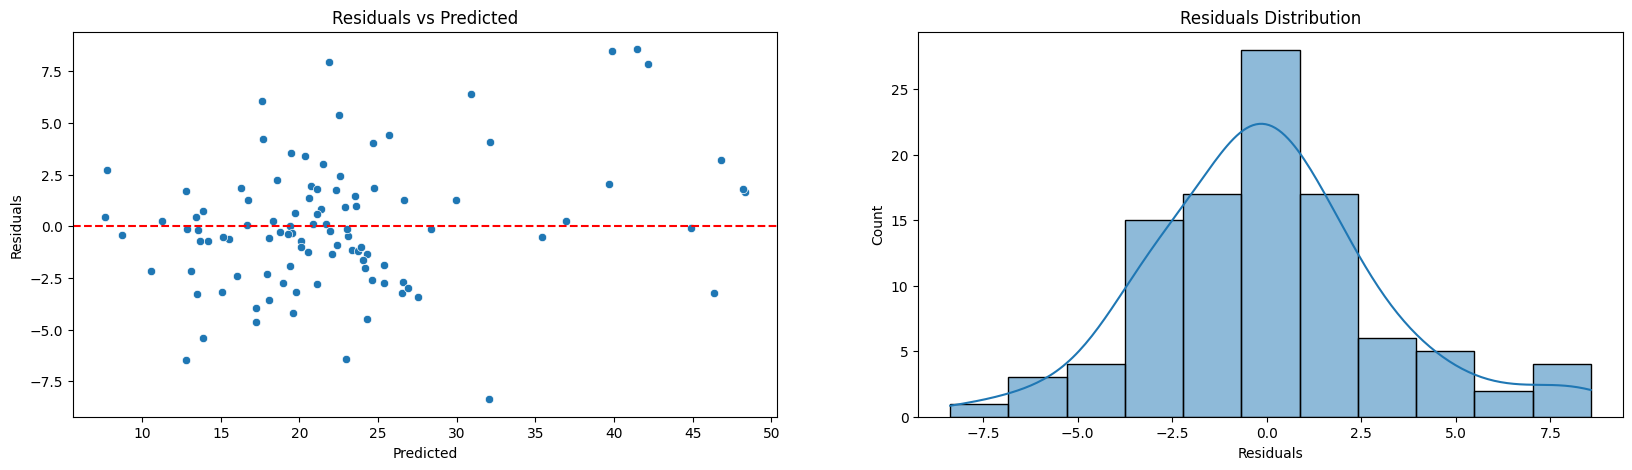

In [7]:
residuals = y_test - default_y_pred

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

# Residuals vs Fitted
sns.scatterplot(x=default_y_pred, y=residuals, ax=ax1)
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Residuals")
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title("Residuals vs Predicted")

# Histogram
sns.histplot(residuals, kde=True, ax=ax2)
ax2.set_xlabel("Residuals")
ax2.set_title("Residuals Distribution")
plt.show()

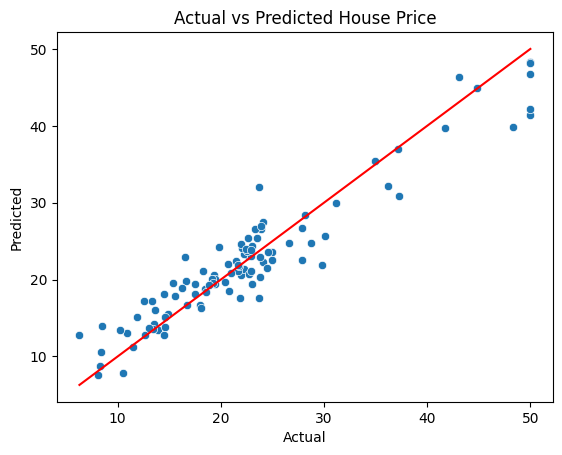

In [8]:
sns.scatterplot(x=y_test, y=default_y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted House Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')   
plt.show()

In [9]:
res = {}

mae_train = mean_absolute_error(y_train, default_y_pred_train)
rmse_train = root_mean_squared_error(y_train, default_y_pred_train)
r2_train = r2_score(y_train, default_y_pred_train)

# test metrics
mae = mean_absolute_error(y_test, default_y_pred)
rmse = root_mean_squared_error(y_test, default_y_pred)
r2 = r2_score(y_test, default_y_pred)

residuals = y_test - default_y_pred

res["default"] = {
    "model": config["name"],
    
    "train_mae": mae_train,
    "train_rmse": rmse_train,
    "train_r2": r2_train,
    
    "test_mae": mae,
    "test_rmse": rmse,
    "test_r2": r2,
    "rmse_gap": rmse - rmse_train,
}
res


{'default': {'model': 'XGBRegressor',
  'train_mae': 0.007549762017656112,
  'train_rmse': 0.010865894638077698,
  'train_r2': 0.9999985384297829,
  'test_mae': 2.2952071479722562,
  'test_rmse': 3.099806882469507,
  'test_r2': 0.9027718655671774,
  'rmse_gap': 3.088940987831429}}

## CV model (GridSearch)

In [10]:
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

search = GridSearchCV(config["class"](), param_grid, cv=10, scoring="r2").fit(x_train, y_train)

In [11]:
search_results = pd.DataFrame(search.cv_results_)
columns = [column for column in search_results if column.startswith('param_')]
columns.append("mean_test_score")
columns.append("rank_test_score")
search_results[columns].sort_values(by='mean_test_score', ascending=False)

,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,rank_test_score
11,0.015,4,700,0.891034,1
10,0.015,4,600,0.889681,2
9,0.015,4,500,0.887129,3
2,0.010,4,700,0.886851,4
1,0.010,4,600,0.884279,5
0,0.010,4,500,0.880935,6
14,0.015,5,700,0.880016,7
13,0.015,5,600,0.879133,8
12,0.015,5,500,0.877703,9
5,0.010,5,700,0.875859,10


In [12]:
print("The best hyperparameters are ",search.best_params_)
search.best_estimator_

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [13]:
best_model = search.best_estimator_
y_pred = best_model.predict(x_test)
y_pred_train = best_model.predict(x_train)

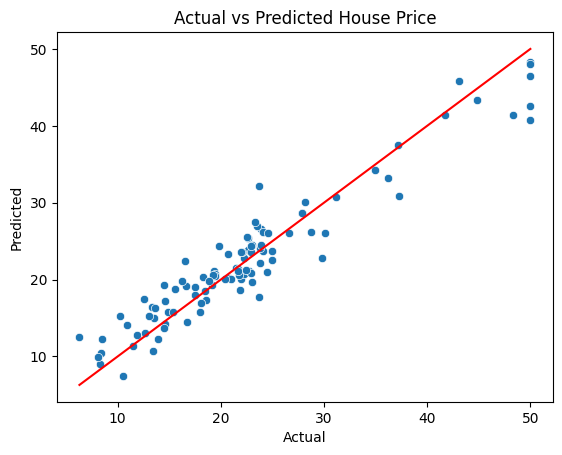

In [14]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted House Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')   
plt.show()

In [15]:
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# test metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

residuals = y_test - y_pred

res["cv"] = {
    "model": config["name"],
    
    "train_mae": mae_train,
    "train_rmse": rmse_train,
    "train_r2": r2_train,
    
    "test_mae": mae,
    "test_rmse": rmse,
    "test_r2": r2,
    "rmse_gap": rmse - rmse_train,
}

In [16]:
pd.DataFrame(res)

,default,cv
model,XGBRegressor,XGBRegressor
train_mae,0.00755,0.689432
train_rmse,0.010866,0.909399
train_r2,0.999999,0.989762
test_mae,2.295207,2.266387
test_rmse,3.099807,2.973629
test_r2,0.902772,0.910526
rmse_gap,3.088941,2.06423


## Comparison of the default and cv models

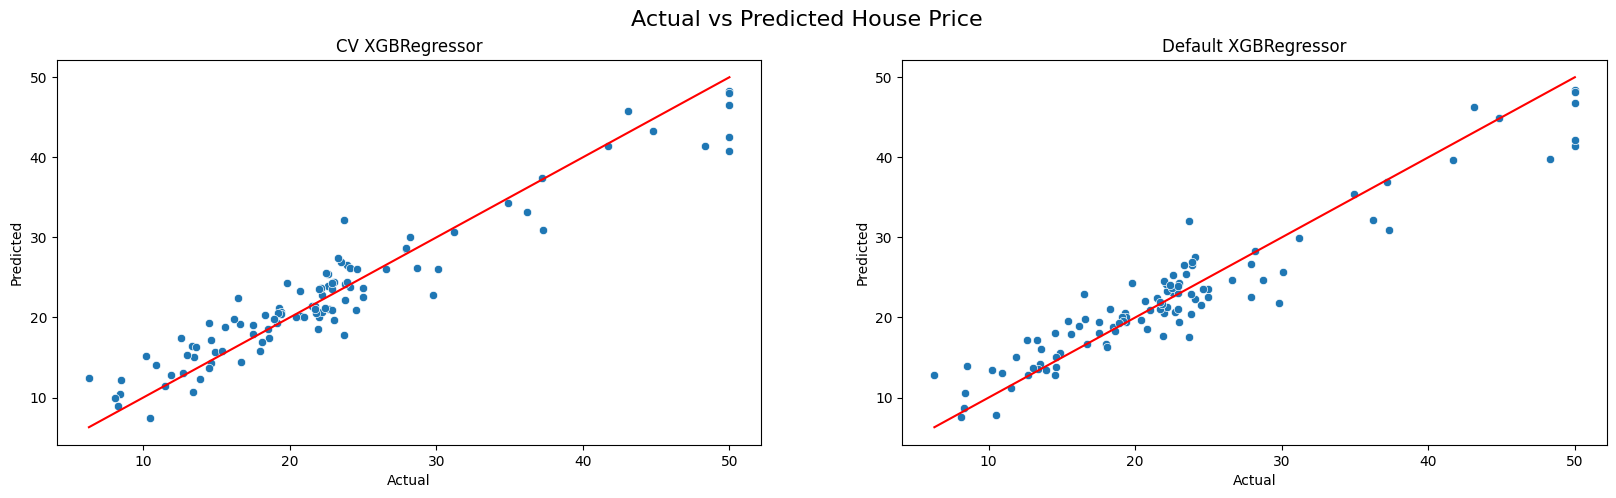

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

sns.scatterplot(x=y_test, y=y_pred, ax=ax1)
ax1.set_xlabel("Actual")
ax1.set_ylabel("Predicted")
ax1.set_title(f"CV {config['name']}")

ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')   

sns.scatterplot(x=y_test, y=default_y_pred, ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_ylabel("Predicted")
ax2.set_title(f"Default {config['name']}")
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')   

fig.suptitle("Actual vs Predicted House Price", fontsize=16)
plt.show()

In [18]:
results = pd.read_csv(MODEL_RESULTS_FILE)

results = results.set_index("model")
model_name = config["name"]
model_file = config["filename"]
new_metrics = res["cv"]
new_r2 = new_metrics["test_r2"]

is_new = model_name not in results.index
is_file = model_file.exists()
is_better = not is_new and (new_r2 > results.at[model_name, "test_r2"])

if not is_file or is_new or is_better:
    results.loc[model_name] = new_metrics
    results.reset_index().to_csv(MODEL_RESULTS_FILE, index=False)
    # update or save the model
    joblib.dump(best_model, model_file)
    print(f"Updated {model_name} with R2: {new_r2}")
else:
    print(f"Existing {model_name} performance is better. Skipping update.")

Existing XGBRegressor performance is better. Skipping update.
